# Notebook Description

This notebook is designed for performing feature ranking using F regression. It utilizes grids from files and user-defined bounding boxes (list of (W, S, E, N) tuples) to create training data.

## Processes:
1. **Read and Convert Predictors:**
   - Open selected predictor files and convert them into pandas Series.
   - Append these Series to a pandas DataFrame.

2. **Read EMAG Target Grid Data:**
   - Open EMAG grid data from a NetCDF file and convert to a pandas Serie..

3. **Handle Missing Values:**
   - Fill missing values in predictor and EMAG target grids with their respective medians.

4. **Perform F Regression:**
   - Utilize `f_regression` from scikit-learn to calculate F-scores and p-values for each predictor variable against the EMAG target.

5. **Store and Sort Results:**
   - Store F-scores and p-values for each predictor file and sort them in descending order based on F-scores.

6. **Visualize Feature Ranking:**
   - Plot a bar chart to visualize the ranking of predictor files based on their F-scores.

### Implementation Details:

- **File Handling:** Utilizes `os` and `netCDF4` libraries to manage and read NetCDF files containing predictor grids.
- **Data Handling:** Uses pandas Series and DataFrames to store and manipulate predictor data.
- **Error Handling:** Includes exception handling for robust processing of NetCDF files.
- **Visualization:** Uses matplotlib to plot a bar chart with log-scaled y-axis for clear visualization of feature ranking.

### Notes:
- This notebook integrates data cleaning, feature selection, and visualization techniques to rank predictor grids based on their predictive power for EMAG

In [1]:
!pip install netCDF4 scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import netCDF4
from netCDF4 import Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression
import matplotlib.pyplot as plt
import os

Initial set up for iterative ranking of variables

In [3]:
# Define the path to the predictors folder on Google Drive
predictors_folder = '/content//'

# Create lists to store predictor data and names
predictor_list = []
scores = []

# List all files in the predictors folder
files = os.listdir(predictors_folder)

# Open the emag target file
emag_file_path = '/content/interpolated_emag_from_csv.nc'
emag_file = netCDF4.Dataset(emag_file_path, 'r')
emag_tar = emag_file.variables['z'][:].flatten()

# Function to handle reading variables from NetCDF files
def read_variable(nc_file, var_name):
    try:
        return nc_file.variables[var_name][:].flatten()
    except KeyError:
        print(f"Variable '{var_name}' not found in NetCDF file.")
        return None

Iterating over the predictors and taking account of their scores

In [4]:

# Iterate over each file in the predictors folder
for file_name in files:
    file_path = os.path.join(predictors_folder, file_name)

    # Skip the emag target file itself and non-NetCDF files
    if file_name == 'interpolated_emag_from_csv.nc' or not file_name.endswith('.nc'):
        continue

    try:
        # Open the predictor file
        predictor_file = netCDF4.Dataset(file_path, 'r')


        # Read predictor data
        predictor_data = read_variable(predictor_file, 'z')

        # fill with median
        predictor_series = pd.Series(predictor_data)
        predictor_filled = predictor_series.fillna(predictor_series.median())
        predictor_data_filled = predictor_filled.values

        #fill emag_tar with median
        emag_tar_series = pd.Series(emag_tar)
        emag_tar_filled = emag_tar_series.fillna(emag_tar_series.median())
        emag_tar = emag_tar_filled.values



        # Perform feature selection using F-regression
        score = f_regression(predictor_data_filled.reshape(-1, 1), emag_tar.flatten())

        # Store results
        scores.append((file_name, score[0][0], score[1][0]))

        # Close predictor file
        predictor_file.close()

    except Exception as e:
        print(f"Error processing {file_name}: {str(e)}")

# Sort scores by F-score in descending order
scores.sort(key=lambda x: x[1], reverse=True)


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, ord

# Feature Ranking Bar Plot

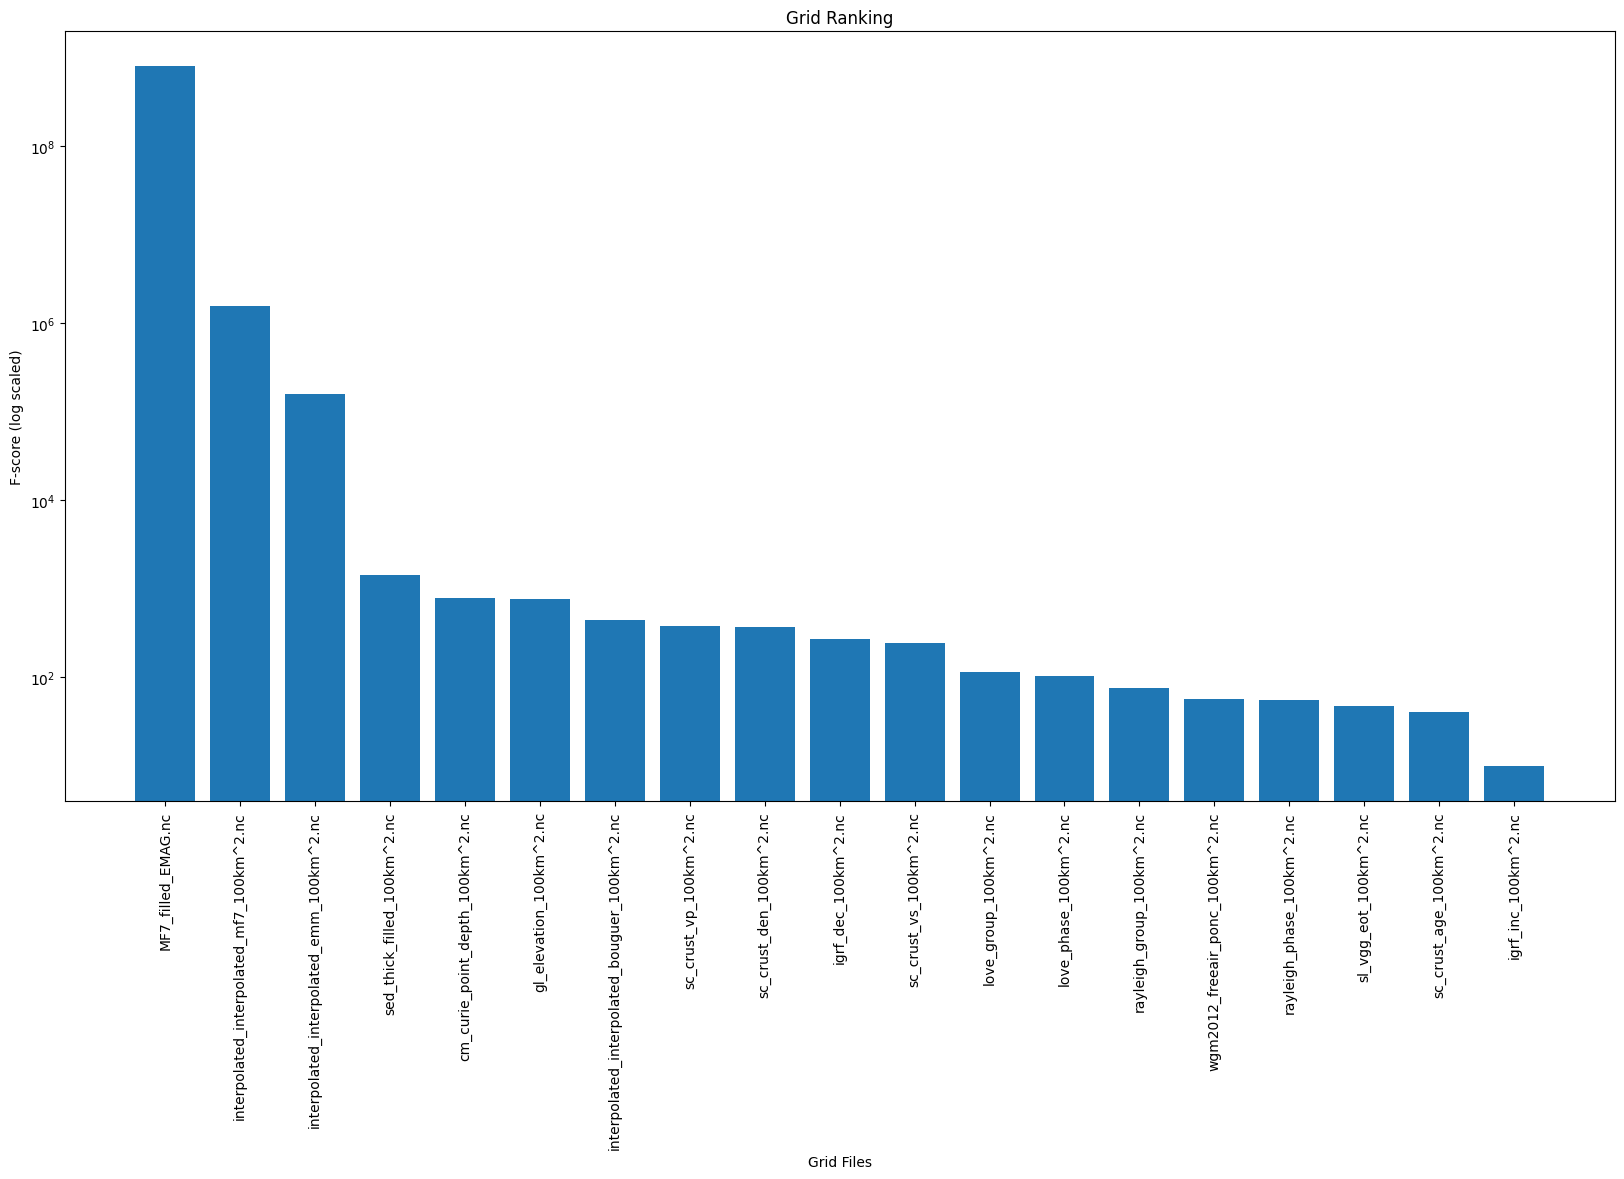

In [5]:
# Plotting the results
fig = plt.figure(figsize=(20, 10))
filebar = [x[0] for x in scores]
scorebar = [x[1] for x in scores]
plt.bar(filebar, scorebar)
plt.yscale('log')
plt.title('Grid Ranking')
plt.xlabel('Grid Files')
plt.ylabel('F-score (log scaled)')
plt.xticks(rotation=90)
plt.show()

# F-Score Meaning

In feature selection for predictive modeling, F-scores are statistical measures used to evaluate the significance of individual predictor variables in relation to the target variable. Specifically, F-scores quantify the degree of linear dependency between each predictor variable and the target variable, typically in the context of regression tasks.

## Understanding F-Scores:

- **Higher F-Score:** Indicates a stronger linear relationship between the predictor variable and the target variable. Variables with higher F-scores are considered more relevant for predicting the target variable's variation.

- **Lower F-Score:** Suggests a weaker linear relationship or no significant relationship between the predictor and target variables. Such variables may contribute less to the predictive power of the model.

## Calculation:

F-scores are computed based on the ratio of two variances:
- **Between-group variance:** Measures how much the means of different groups (defined by the levels of the predictor variable) differ from each other.
- **Within-group variance:** Reflects the variability of data points within each group.

The F-score is the ratio of these variances normalized by the degrees of freedom, and it follows an F-distribution under the null hypothesis (no relationship between predictor and target).

